In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif     
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_validate,
    learning_curve
)
from sklearn.metrics import (
    classification_report,
    RocCurveDisplay,
    confusion_matrix
)

## Time Series Tasks

In [16]:
longitudinal_df = pd.read_csv('patient_longitudinal.csv', delimiter='\t')
print(longitudinal_df.describe())
print(longitudinal_df.info())

         patient_id   bp_systolic    heart_rate  adverse_event           age  \
count  61000.000000  61000.000000  61000.000000   61000.000000  61000.000000   
mean     499.500000    134.454487     77.983184       0.094492     50.319300   
std      288.677356     18.642552     18.107739       0.292514     14.463437   
min        0.000000     51.600000      1.800000       0.000000     18.000000   
25%      249.750000    122.100000     66.000000       0.000000     40.275000   
50%      499.500000    134.300000     77.900000       0.000000     50.400000   
75%      749.250000    146.800000     89.600000       0.000000     59.700000   
max      999.000000    209.700000    152.800000       1.000000     90.000000   

                sex           bmi       smoking      diabetes  
count  61000.000000  61000.000000  61000.000000  61000.000000  
mean       0.515000     27.095600      0.274000      0.282000  
std        0.499779      4.880253      0.446013      0.449977  
min        0.000000    

In [20]:
#fix datatypes
longitudinal_df.sex = longitudinal_df.sex.astype(int)
longitudinal_df.smoking = longitudinal_df.smoking.astype(int)
longitudinal_df.diabetes = longitudinal_df.diabetes.astype(int)
longitudinal_df.adverse_event = longitudinal_df.adverse_event.astype(int)

In [21]:
# 1. Convert the longitudinal blood pressure measurements into a proper time series:
#    - Create a pandas Series with DatetimeIndex using `visit_date`
#    - Handle any missing or duplicate measurements appropriately
#    - Tips: 
#      - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
#      - Handle duplicates with `duplicated()` and appropriate aggregation
#      - Consider timezone handling with `tz_localize()` if needed
#      - Use `interpolate()` or `fillna()` for missing values

longitudinal_df['visit_date'] = pd.to_datetime(longitudinal_df['visit_date'], format='%Y-%m-%d')
bp_series = longitudinal_df.set_index('visit_date')['bp_systolic']

bp_series = bp_series.groupby(level=0).mean() #take mean of duplicated days
bp_series = bp_series.interpolate()  # fill missing values

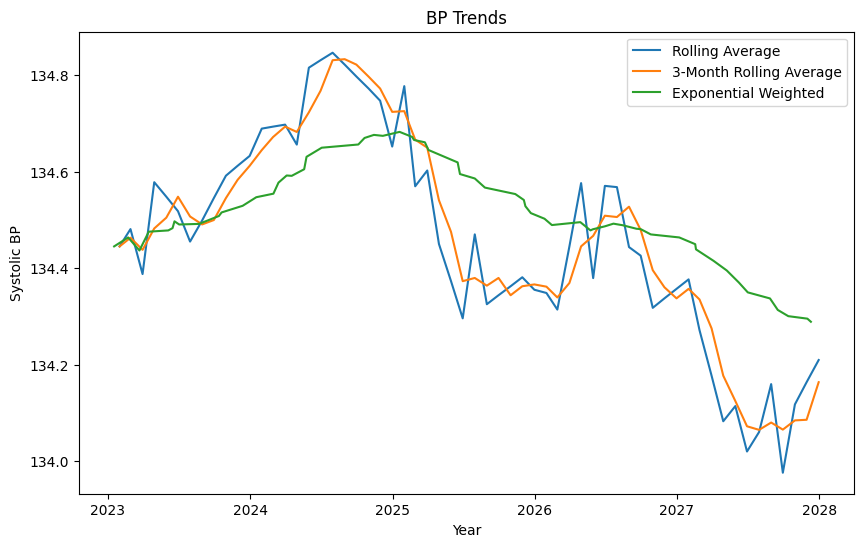

'\nThere is an overall decline of BP over time, though the trend indicates two crests and two troughs;\noverall the fluctuation is minor, since the BP range is minimal between 134-135\n'

In [31]:
# 2. Analyze blood pressure trends:
#    - Resample the data to monthly frequency using mean aggregation
#    - Calculate 3-month moving averages to smooth out short-term fluctuations
#    - Visualize both the original and smoothed trends
#    - Tips:
#      - Use `resample('ME').mean()` for month-end frequency
#      - Add `min_periods` to `rolling()` to handle edge cases
#      - Consider `interpolate()` method for gaps
#      - Use `ewm()` for exponential weighted alternatives

monthly_bp = bp_series.resample('M').mean()
monthly_bp = monthly_bp.interpolate()
monthly_bp_smooth = monthly_bp.rolling(window=3, min_periods=1).mean()
ewm_bp = bp_series.ewm(span=30).mean() #give more weight to recent observations for 30-day span

plt.figure(figsize=(10, 6))
plt.plot(monthly_bp, label='Rolling Average')
plt.plot(monthly_bp_smooth, label='3-Month Rolling Average')
plt.plot(ewm_bp, label='Exponential Weighted')
plt.xlabel('Year')
plt.ylabel('Systolic BP')
plt.title('BP Trends')
plt.legend()
plt.show()

'''
There is an overall decline of BP over time, though the trend indicates two crests and two troughs;
overall the fluctuation is minor, since the BP range is minimal between 134-135
'''

## Statistical Modeling Tasks

In [37]:
baseline_df = pd.read_csv('patient_baseline.csv', delimiter='\t')
treatment_df = pd.read_csv('patient_treatment.csv', delimiter='\t')

# print(baseline_df.describe())
# print(baseline_df.info())

#fix datatypes
baseline_df.sex = baseline_df.sex.astype(int)
baseline_df.smoking = baseline_df.smoking.astype(int)
baseline_df.diabetes = baseline_df.diabetes.astype(int)
print(baseline_df.describe())
print(baseline_df.info())

        patient_id          age          sex          bmi      smoking  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    499.500000    50.319300     0.515000    27.095600     0.274000   
std     288.819436    14.470555     0.500025     4.882655     0.446232   
min       0.000000    18.000000     0.000000    15.000000     0.000000   
25%     249.750000    40.275000     0.000000    23.800000     0.000000   
50%     499.500000    50.400000     1.000000    27.000000     0.000000   
75%     749.250000    59.700000     1.000000    30.300000     1.000000   
max     999.000000    90.000000     1.000000    43.000000     1.000000   

          diabetes  bp_systolic  cholesterol  heart_rate  
count  1000.000000  1000.000000  1000.000000   1000.0000  
mean      0.282000   134.552400   205.390400     77.4556  
std       0.450198    12.408951    22.125587     11.5321  
min       0.000000    97.500000   140.300000     44.5000  
25%       0.000000   125.875000   190.

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        16:26:32   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

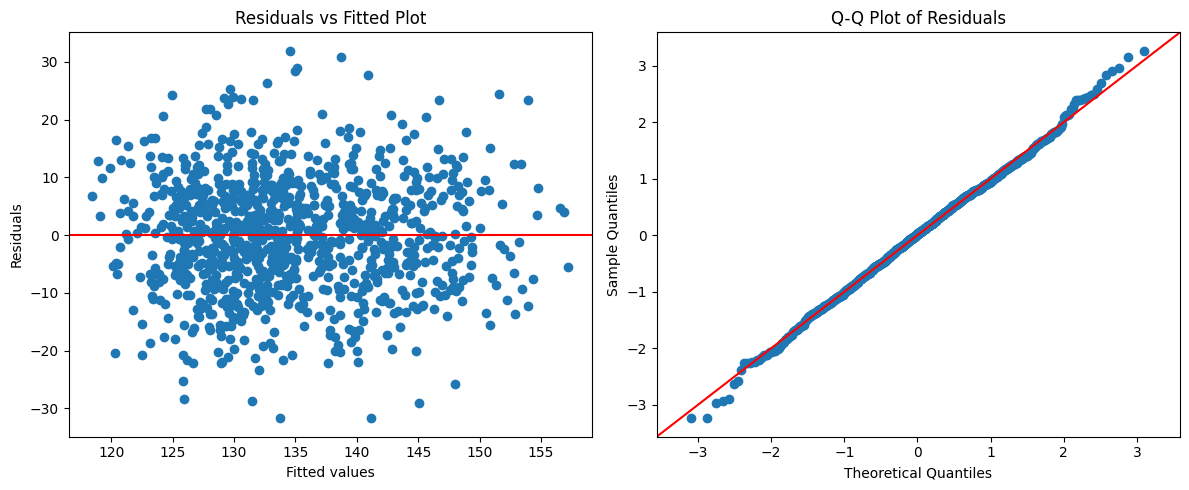

In [36]:
# 1. Analyze factors affecting baseline blood pressure:
#    - Use statsmodels OLS to predict `bp_systolic`
#    - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
#    - Interpret the coefficients and their p-values
#    - Assess model fit using R-squared and diagnostic plots
#    - Tips:
#      - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
#      - Use `sm.OLS(y, X).fit()` to fit the model
#      - Use `summary()` to examine p-values and confidence intervals
#      - Plot residuals vs fitted values and Q-Q plot
#      - Consider robust standard errors with `HC3` covariance type

X = sm.add_constant(baseline_df[['age', 'bmi', 'smoking', 'diabetes']])
y = baseline_df['bp_systolic']

model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

# Diagnostic plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# residuals vs. fitted
ax1.scatter(model.fittedvalues, model.resid)
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted Plot')
ax1.axhline(y=0, color='r')

#qq plot
sm.graphics.qqplot(model.resid, fit=True, line='45', ax=ax2)
ax2.set_title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

'''
The fit seems to look god since the residuals are evenly distributed about the x-axis. The data also
seems to be normally distributed since the points lie close tot he diagonal line on the Q-Q plot.
However, since the R^2 value is relatively low ~.376 we note that the model only explains a low 
proportion of variance in the data.
age coeff = .284; p-val ~ 0; this implies that controlling for all other factors, an increase in one
year in age reflects an increase in .284 in BP, on average.
bmi coeff = .279; p-val ~0; this implies that controlling for all other factors, an increase in one
bmi unit reflects an increase in .278 in BP, on average.
smoking coeff = 5.24; p-val ~0; this implies that controlling for all other factors, smoking 
reflects in increase in 5.24 in BP, on average.
diabetes coeff = 9.87; p-val ~0; this implies that controlling for all other factors, having diabetes
reflects in increase in 9.87 in BP, on average.
'''

Odds Ratios:
const          0.029521
age            0.996469
sex            0.892022
bmi            1.026068
smoking        0.597965
bp_systolic    1.008961
cholesterol    1.006952
heart_rate     1.001884
diabetes       0.564716
adherence      1.162271
dtype: float64
CIs:
                    0         1
const        0.002552  0.341510
age          0.985829  1.007224
sex          0.687935  1.156654
bmi          0.997521  1.055431
smoking      0.390961  0.914572
bp_systolic  0.995734  1.022364
cholesterol  1.000515  1.013431
heart_rate   0.989644  1.014275
diabetes     0.393795  0.809823
adherence    0.312541  4.322228


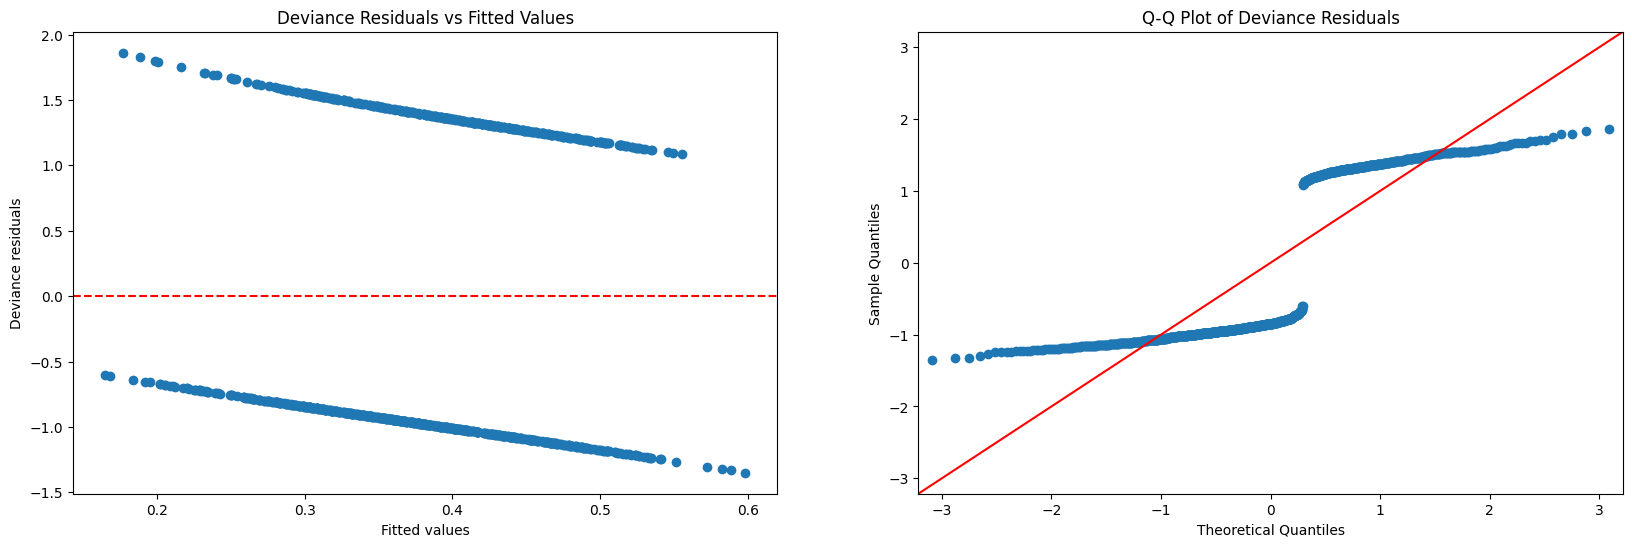

Null Deviance: 1331.9768185036041
Residual Deviance: 1305.8118647624287

Top 5 influential observations:
108    0.005316
14     0.005227
223    0.004656
709    0.004560
239    0.004231
dtype: float64


"\nSince the residual deviance is slightly lower than the null, the model is doing slightly better\nat explaining the variance. The fit seems to be ok, we have the binary outcome plotted on two plots\nwith very symmetrical distributions about the axes or qq diagonmal line. The are almost horizontal\nfor the deviance plot which is good. There doesn't seem to be influential points, but cooks distance\nwas used to find the top 5 influential point indices and their corresponding values.\n"

In [46]:
# 2. Model treatment effectiveness:
#    - Fit a GLM with binomial family to predict treatment success
#    - Use baseline characteristics and `adherence` as predictors
#    - Report odds ratios and their confidence intervals
#    - Assess model fit using deviance and diagnostic plots
#    - Tips:
#      - Create feature matrix `X` with predictors and add constant term
#      - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
#      - Get odds ratios with `np.exp(params)`
#      - Check residual deviance vs null deviance
#      - Use `influence()` to detect influential observations

X = sm.add_constant(treatment_df[['age', 'sex', 'bmi', 'smoking', 'bp_systolic', 'cholesterol', 
                                    'heart_rate', 'diabetes', 'adherence']])
y = treatment_df['outcome']
glm_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
# print(glm_model.summary())
odds_ratios = np.exp(glm_model.params)
print("Odds Ratios:")
print(odds_ratios)
print("CIs:")
print(np.exp(glm_model.conf_int()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

#Deviance plot
ax1.scatter(glm_model.fittedvalues, glm_model.resid_deviance)
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Deviance residuals')
ax1.set_title('Deviance Residuals vs Fitted Values')
ax1.axhline(y=0, color='r', linestyle='--')

# Q-Q Plot of Deviance 
sm.graphics.qqplot(glm_model.resid_deviance, line='45', ax=ax2)
ax2.set_title('Q-Q Plot of Deviance Residuals')
plt.show()


print("Null Deviance:", glm_model.null_deviance) #1331.98
print("Residual Deviance:", glm_model.deviance) #1305.81

#influential points
cooks_d = glm_model.get_influence().cooks_distance[0]
cooks_d_series = pd.Series(cooks_d, index=X.index)
print("\nTop 5 influential observations:")
print(cooks_d_series.nlargest(5))

'''
Since the residual deviance is slightly lower than the null, the model is doing slightly better
at explaining the variance. The fit seems to be ok, we have the binary outcome plotted on two plots
with very symmetrical distributions about the axes or qq diagonmal line. The are almost horizontal
for the deviance plot which is good. There doesn't seem to be influential points, but cooks distance
was used to find the top 5 influential point indices and their corresponding values.
'''

## Machine Learning Tasks (stretch goal)

In [50]:
# 1. Build a prediction pipeline:
#    - Create features from baseline characteristics
#    - Standardize numeric features using `StandardScaler`
#    - Train a logistic regression model to predict treatment outcomes
#    - Include regularization to prevent overfitting
#  - Use `ColumnTransformer` for mixed numeric/categorical features
#  - Consider `SelectKBest` or `RFE` for feature selection
#  - Try different regularization strengths with `C` parameter
#  - Use `Pipeline` to prevent data leakage


X = treatment_df.drop(['patient_id', 'adherence', 'outcome', 'treatment'], axis=1)
y = treatment_df['outcome']

# Identify numeric and categorical columns
categorical_features = X.loc[:, ['sex', 'smoking', 'diabetes']].columns
# print(categorical_features)
numeric_features = X.drop(columns=categorical_features).columns
# print(numeric_features)

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# pipeline
pipeline = make_pipeline(
    preprocessor,
    SelectKBest(f_classif, k=5),
    LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
)

Cross-validation results:
accuracy: 0.541
precision: 0.428
recall: 0.580
roc_auc: 0.567

Confusion Matrix:
[[102  83]
 [ 51  64]]


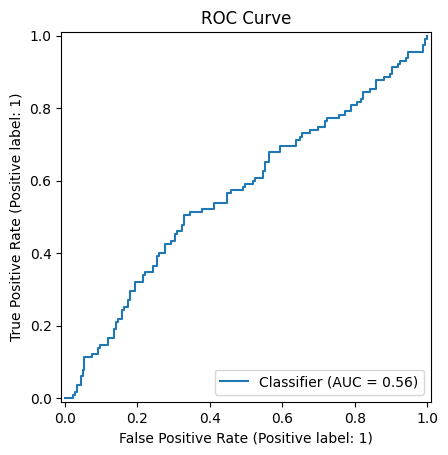

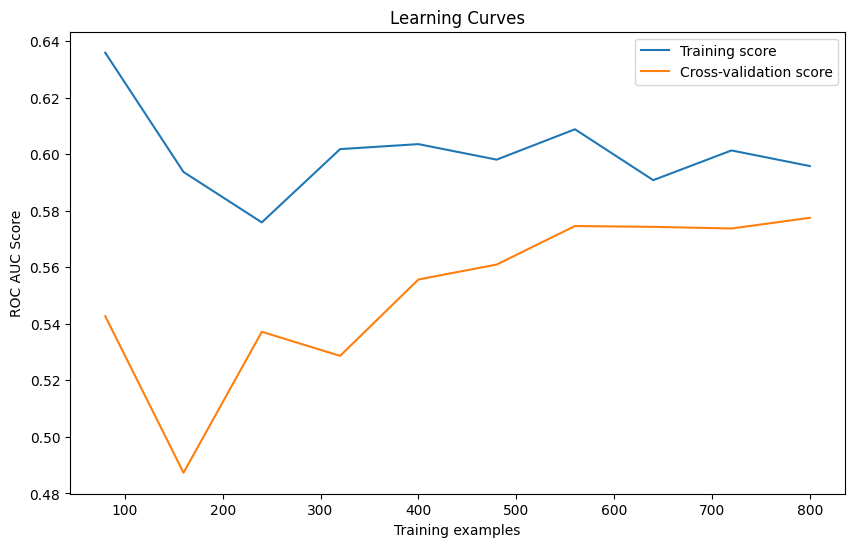

In [51]:
# 2. Validate model performance:
#    - Split data into 70% training and 30% test sets
#    - Implement 5-fold cross-validation on the training set
#    - Report accuracy, precision, recall, and ROC AUC
#    - Generate confusion matrix and ROC curve
    # - Use `StratifiedKFold` for imbalanced datasets
    # - Consider precision-recall curve for imbalanced data
    # - Plot learning curves to diagnose bias/variance
    # - Use `cross_validate` for multiple metrics at once


# Stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

#cross-validation results
print("Cross-validation results:")
for metric, values in scores.items():
    if metric.startswith('test_'):
        print(f"{metric[5:]}: {values.mean():.3f}")

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot ROC curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
plt.title('ROC Curve')
plt.show()

#Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='roc_auc'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

''' 
The CV results aren't that great, with the accuracy, precision, recall and roc_auc scores being
realtively low. Same with the confusion matrix; we observe on the ROC curve the model doesn't 
discriminate too well and doesn't have high area coverage. The learning cure
'''